In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import io
import urllib.request
import datetime
import gzip
import geopandas as gpd
import os
import zipfile as zf
import shapefile
from shapely.geometry import shape

### Importing data

Importing file with world country borders as coordinates

In [2]:
zp = zf.ZipFile('TM_WORLD_BORDERS-0.3.zip')
files_to_read = [y for y in zp.namelist() for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]
dummy = zp.read(files_to_read[0])
dbf_file, prj_file, shp_file, shx_file = [zp.open(filename) for filename in files_to_read]
r = shapefile.Reader(shp = shp_file, shx = shx_file, dbf = dbf_file, encoding='windows-1252')
attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]
for row in r.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names, row.record)))
#Creating a GeoDataframe of the World Borders
gdf = gpd.GeoDataFrame(data = attributes, geometry = geometry)

Scraping temperature anomlalies from NASA dataset

In [3]:
url = "https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz"
req = urllib.request.Request(url)
with gzip.open(urllib.request.urlopen(req)) as resp:
    xr_df = xr.open_dataset(io.BytesIO(resp.read()))
dfnasa = xr_df.to_dataframe()
#Transforming into pandas dataframe
dfnasa = dfnasa.reset_index()

Loading GDP data for the United States

In [10]:
GDPus = pd.read_csv("GDPC1.csv")

### Data Manipulation

Set year from which to obtain data and country

In [4]:
year = 1947
iso3= "USA"

In [5]:
def tempdata(year, iso3):
    #Subsetting the year range from the provided year
    tempyear = dfnasa[dfnasa['time'].dt.year >= year]
    #Creating a GeoDataFrame
    tempyear = gpd.GeoDataFrame(tempyear, geometry=gpd.points_from_xy(tempyear.lon, tempyear.lat))
    #Merging with the border data
    bord = gpd.sjoin(gdf, tempyear, how="inner")
    yearcountry = bord[bord["ISO3"]==iso3]
    #Sorting values by time
    yearcountry = yearcountry.sort_values(by=["time"])
    yearcountry = pd.DataFrame(yearcountry)
    yearcountry = yearcountry.drop(columns= ["FIPS", "UN", "AREA","POP2005", "index_right", "nv"])
    yearcountry["YearMonth"]=yearcountry["time"].dt.strftime("%Y-%m")
    del tempyear
    return yearcountry

Creating DataFrame for selected country and year with country name and ISO3 code added

In [6]:
df = tempdata(year,iso3)
df

Create DataFrame with only Max and Min temperatures

In [12]:
df2 = (df.assign(Data_Value=df['tempanomaly'].abs())
       .groupby(['time'])['tempanomaly'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('time'))
df2 = df2.reset_index()

Adding Year and Month data to the GDP and interpolating monthly values from quarterly data

In [11]:
# Convert to period
GDPus['Month'] = pd.to_datetime(GDPus['DATE']).dt.to_period('M')
# Set Date as index and resample
GDPus2 = GDPus.set_index('Month').resample('M').interpolate()
#Reset index
GDPus2 = GDPus2.reset_index()
#Create time variable
GDPus2['time'] = GDPus2['Month'].astype(str)
GDPus2['time'] = pd.to_datetime(GDPus2['time'])
#Drop unnecessary columns
GDPus2.drop(["Month", "DATE"], inplace= True, axis =1)

Merging temperature anomalies and GDP Data

In [13]:
#Merging temperature anomalies with GDP data
mapping = dict(zip(GDPus2.time.dt.to_period('M'), GDPus2.GDPC1))
df2 = df2.assign(gdp=df2.time.dt.to_period('M').map(mapping))
df2 = df2.reset_index()
df2.drop("index", axis =1, inplace=True)

In [14]:
df2

time  timeMin  timeMax           gdp
0   1947-01-15    -6.66     4.33   2033.061000
1   1947-02-15    -3.48     3.51   2031.253667
2   1947-03-15    -3.64     4.59   2029.446333
3   1947-04-15    -1.90     1.61   2027.639000
4   1947-05-15    -2.55     2.46   2026.243333
..         ...      ...      ...           ...
887 2020-12-15    -0.27     5.58  18989.854000
888 2021-01-15     0.48     7.10  19087.568000
889 2021-02-15    -4.14     1.27           NaN
890 2021-03-15    -1.28     5.49           NaN
891 2021-04-15    -0.95     2.38           NaN

[892 rows x 4 columns]

Export to pickle

In [15]:
df2.to_pickle("GDP_temperature_anomalies_"+str(year)+"_"+iso3+".pkl")

### Daily Maximum temperatures in the United States

The temperature of 210 US cities was obtaind from this website: https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488

Then all the temperertures have been concatenated into one big dataframe. Then, for each day, the maximum overall temperature was selected and reported in order to obtain a daily time series of the peak temperature reached in one of these 210 cities.

In [ ]:
'''
path =r'C:\Users\fiora\Desktop\root\01_Projects\02_Coding\02_Python\07_GitHub\MDA\modern-data-analytics\TempScraping\uscities'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
 Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)
'''

Importing pickle with concatenated temperatures for all 210 cities

In [2]:
big_frame = pd.read_pickle("big_frame.pkl")

Grouping per day and returning max temperature

In [4]:
dfmax = (big_frame.assign(Data_Value=big_frame['tmax'].abs())
       .groupby(['Date'])['tmax'].agg([('Max', "max")])
       .add_prefix('Date'))

Function to convert to Celsius from Farenheit

In [5]:
def far_to_cel(far):
    cel = (far - 32) * 5/9
    return cel

In [6]:
dfmaxcel = dfmax.apply(lambda x: far_to_cel(x), axis=1)

In [ ]:
dfmaxcel.to_pickle("dfmaxcel.pkl")

<AxesSubplot:xlabel='Date'>

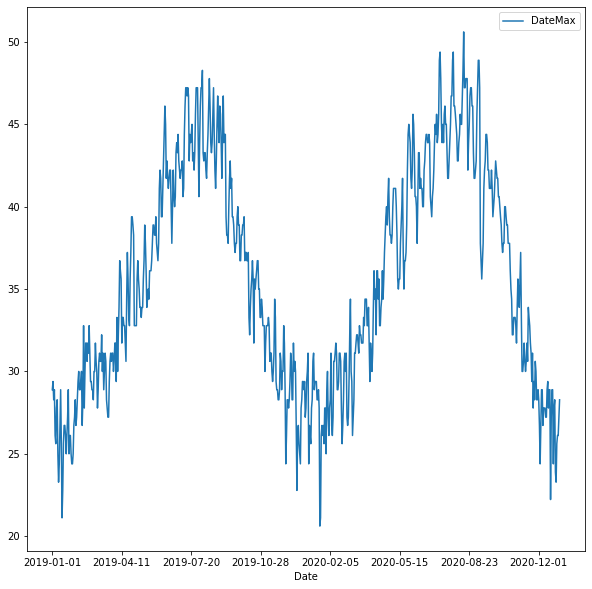

In [8]:
dfmaxcel['2019':].plot(figsize=(10, 10))